### Comparison with temperature gradients / heat flow. 

There are some heat flow / temperature gradient data available (e.g. Batir et al. (1) and references therein). 
The maps presented there add additional information
from geological setting, the locations of volcanic belts and hot springs. In this case, we have applied the same surface fitting algorithm 
used for the moho to the available measurements for surface heat flow. 

--- 

Notebooks in this section:

 
--- 

(1) Batir, J. F., D. D. Blackwell, and M. C. Richards (n.d.), Updated surface heat flow map of Alaska, GRC Transactions, 37, 927–932.

In [13]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import litho1pt0


In [18]:
## These are the original data 
mohoraw = np.load("Models/AlaskaMohoErrs.npz")['alaska_moho']
mohorawgrid = stripy.sTriangulation(np.radians(mohoraw['lon']), np.radians(mohoraw['lat']), tree=True, permute=False)

msmohoF = np.load("Models/AlaskaMoHiErrs-AlaskaMohoFineGrid.npz")
print(msmohoF.keys())

msmhfF = np.load("Models/AlaskaHeatFlowFineGrid.npz")
print(msmhfF.keys())

['gridded_data_1', 'gridded_data_3', 'gridlons', 'gridded_data_2', 'gridded_data_slope_3', 'gridded_data_slope_2', 'gridded_data_slope_1', 'gridlats', 'quality']
['gridlons', 'gridded_data_1pct_m', 'gridded_data_1pct_j', 'gridded_dataj', 'gridlats', 'quality', 'gridded_data']


In [19]:
lons = msmohoF['gridlons']
lats = msmohoF['gridlats']

gridF = stripy.sTriangulation(lons%(2.0*np.pi), lats, permute=True)
gridF_interpolation_1pct_j   = msmohoF['gridded_data_1']
gridF_interpolation_1pct_j_s = msmohoF['gridded_data_slope_1']
gridF_interpolation   = msmohoF['gridded_data_2']
gridF_interpolation_s = msmohoF['gridded_data_slope_2']
gridF_quality = msmohoF['quality']

lons = msmhfF['gridlons']
lats = msmhfF['gridlats']

gridFh = stripy.sTriangulation(lons%(2.0*np.pi), lats, permute=True)
gridFh_interpolation   = msmhfF['gridded_data']
gridFh_interpolation_j   = msmhfF['gridded_dataj']
gridFh_interpolation_1pct_j   = msmhfF['gridded_data_1pct_j']
gridFh_interpolation_1pct_m   = msmhfF['gridded_data_1pct_m']
gridFh_quality = msmhfF['quality']

In [20]:
def alaska_moho_plot(filename, 
                     grid, 
                     data, 
                     quality, 
                     plot_range=[25.0, 50.0], 
                     show_coastline=True,
                     show_bg_image=True,
                     raw_data_points=None,
                     cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    
         
    try:   
        import gdal
        globalsrelief       = gdal.Open("../ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]/4, 0:globalsrelief_img.shape[1]/4]
    except ImportError:
        show_bg_image = False


   
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])
    
    
    grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", name="graticules_5")
    ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=2)
    

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)
    
    gdata2 = grid_data.copy()
    gdata2[ quality == 0.0 ] = -10000000
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", 
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.25,
                         zorder=10)
    
    gdata2 = grid_data.copy()
    gdata2[ quality < 0.05 ] = -10000000
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", 
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.25,
                         zorder=11)
    
    gdata2 = grid_data.copy()
    gdata2[ quality  < 0.1 ] = -10000000

    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.5,
                         zorder=12)

       
    if raw_data_points is not None:

        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

 

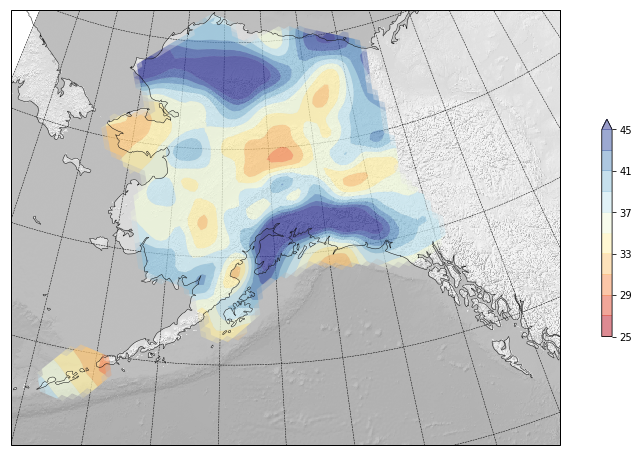

In [21]:
alaska_moho_plot("Images/AlaskaMoho1pctJ.png", 
                 gridF, gridF_interpolation_1pct_j, 
                 gridF_quality, 
                 plot_range=[25, 45],
                 show_bg_image=True )


In [22]:
def alaska_moho_slope_plot(filename, 
                           grid, 
                           data, 
                           grad,
                           quality, 
                           plot_range=[25.0, 50.0], 
                           show_coastline=True,
                           show_bg_image=True,
                           raw_data_points=None,
                           cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    grad_data = grad

    
    if cmap == None:
        cmap = plt.cm.Oranges
        
        
        
    try:   
        import gdal
        globalsrelief       = gdal.Open("../ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]/4, 0:globalsrelief_img.shape[1]/4]
    except ImportError:
        show_bg_image = False




    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-170,-130,50,70])

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)
  
    gdata2 = grad_data.copy()
    gdata2[ quality == 0] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(0.0,0.15,16),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.75,
                         zorder=10)
    
    centroids_q, err = gridF.interpolate(gridF.lons[gridF.simplices].mean(axis=1), 
                                    gridF.lats[gridF.simplices].mean(axis=1), quality)
    
    
    mask = centroids_q == 0.0

    cnt=ax1.tricontour(lons, lats, goodgrid.simplices, grid_data, 
                   alpha=1.0, colors="#000000", mask=mask,
                   levels=[25, 29, 33, 37, 41, 45],
                   linewidths=[0.5,0.5, 0.75, 0.75, 1.0, 1.0],
                   linestyles=[":","-"],
                   transform=ccrs.PlateCarree(), 
                       zorder=50) 
  
    ## Mask by "quality" of the interpolation
   
    ## Locations of raw data collection

    if raw_data_points is not None:
        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )



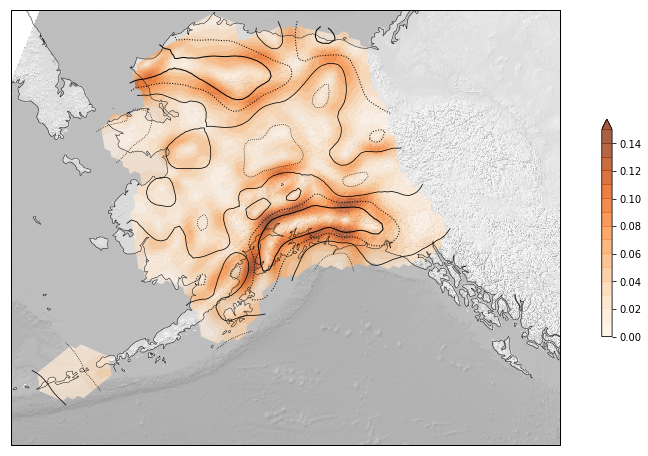

In [23]:
alaska_moho_slope_plot("Images/AlaskaMohoSlope1pctJ.png", 
                        gridF, gridF_interpolation_1pct_j, gridF_interpolation_1pct_j_s / 6371,
                        gridF_quality, 
                        plot_range=[25, 45],
                        show_bg_image=True )

In [24]:
def alaska_moho_heat_plot(filename, 
                           grid, 
                           gridh,
                           data, 
                           datah,
                           quality, 
                           qualityh, 
                           plot_range=[25.0, 50.0], 
                           show_coastline=True,
                           show_bg_image=True,
                           raw_data_points=None,
                           cmap=None ):
    
    goodgrid = grid
    goodgridh = gridh
    interpolation_quality = quality
    interpolation_qualityh = qualityh
    grid_data = data
    grid_datah = datah

    if cmap == None:
        cmap = plt.cm.RdYlBu_r
        
        
    try:   
        import gdal
        globalsrelief       = gdal.Open("../ShadedRelief/GRAY_HR_SR_OB.tif")
        globalsrelief_img   = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
        globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]/4, 0:globalsrelief_img.shape[1]/4]
    except ImportError:
        show_bg_image = False





    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    
    
    
    ax1.set_extent([-170,-130,50,70])

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgridh.lons)%360.0
    lats = np.degrees(goodgridh.lats)
  
    gdata2 = grid_datah.copy()
    gdata2[ qualityh < 0.1] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgridh.simplices, gdata2, 
                   alpha=0.25, 
                   levels=[30, 40, 50, 60, 70, 80, 90, 100],
                   colors=["#64DDFA","#4DAE45","#6BEB47","#FBF752","#F6B740","#D95D27","#DA6045","#CB362D"],
                   extend="max", linewidths=10.0,
                   transform=ccrs.PlateCarree(), zorder=5)

    gdata2 = grid_datah.copy()
    gdata2[ qualityh == 0] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgridh.simplices, gdata2, 
                   alpha=0.5, 
                   levels=[30, 40, 50, 60, 70, 80, 90, 100],
                   colors=["#64DDFA","#4DAE45","#6BEB47","#FBF752","#F6B740","#D95D27","#DA6045","#CB362D"],
                   extend="max", linewidths=10.0,
                   transform=ccrs.PlateCarree(), zorder=5)


   
    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)


    
    centroids_q, err = gridF.interpolate(gridF.lons[gridF.simplices].mean(axis=1), 
                                    gridF.lats[gridF.simplices].mean(axis=1), quality)
    
    
    mask = centroids_q == 0.0

    cnt=ax1.tricontour(lons, lats, goodgrid.simplices, grid_data, 
                   alpha=1.0, colors="#000000", mask=mask,
                   levels=[25, 29, 33, 37, 41, 45],
                   linewidths=[0.5,0.5, 0.75, 0.75, 1.0, 1.0],
                   linestyles=[":","-"],
                   transform=ccrs.PlateCarree(), 
                       zorder=50) 
  
    
    ## Locations of raw data collection

    if(raw_data_points):
        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

   
   
    fig.savefig(filename, dpi=300)

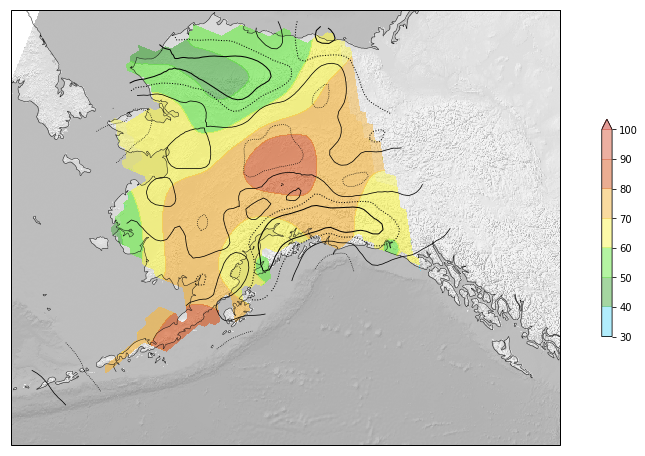

In [29]:
alaska_moho_heat_plot("Images/AlaskaMohoHF.png", 
                        gridF, 
                        gridFh,
                        gridF_interpolation_1pct_j, 
                        gridFh_interpolation_1pct_j,
                        gridF_quality, 
                        gridFh_quality, 
                        plot_range=[20, 80],
                        show_bg_image=True )

In [11]:
import lavavu

lv = lavavu.Viewer(border=False, quality=2)

exaggeration = 5.0

xyz  = np.array(stripy.spherical.lonlat2xyz(np.radians(mohoraw['lon']), np.radians(mohoraw['lat']))).T
xyz  *= (6371 - exaggeration * mohoraw['moh'].reshape(-1,1)) / 6371

points = lv.points(pointsize=3, pointtype="shiny", opacity=0.75)
points.vertices(xyz)
points.values(mohoraw['moh'])
points.colourmap(lavavu.matplotlib_colourmap("RdYlBu"))

xyz  = np.array(stripy.spherical.lonlat2xyz(gridFh.lons, gridFh.lats)).T
mohoh, err = gridF.interpolate(gridFh.lons, gridFh.lats, gridF_interpolation_1pct_j) 
xyz  *= (6371 - exaggeration * mohoh.reshape(-1,1)) / 6371

tris = lv.triangles(wireframe=False)
tris.vertices(xyz)
tris.indices(gridFh.simplices)
tris.values(gridFh_interpolation_j, label="data")
tris.values(gridFh_quality, label="q")
tris.colourmap("(20)#000066 (40)#008822 (55)#FFFF00 (70)#FF5555")
tris.opacitymap([0.0, 1.0, 1.0 ,1.0])
tris["opacityby"] = "q"


# tris.triangles()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()


<IPython.core.display.Javascript object>